# Create your own entities using DPF operators {#ref_create_entities_example}

You can create your field, fields container, or meshed region to use DPF
operators with your own data. The ability to use scripting to create any
DPF entity means that you are not dependent on result files and can
connect the DPF environment with any Python tool.


In [1]:
# Import necessary modules
import numpy as np

from ansys.dpf import core as dpf
from ansys.dpf.core import operators as ops

Create a parallel piped mesh made of linear hexa:


In [2]:
length = 0.1
width = 0.05
depth = 0.1
num_nodes_in_length = 10
num_nodes_in_width = 5
num_nodes_in_depth = 10
mesh = dpf.MeshedRegion()


def search_sequence_numpy(arr, seq):
    """Find a sequence in an array and return its index."""
    indexes = np.where(np.isclose(arr, seq[0]))
    for index in np.nditer(indexes[0]):
        if index % 3 == 0:
            if np.allclose(arr[index + 1], seq[1]) and np.allclose(arr[index + 2], seq[2]):
                return index
    return -1

Add nodes:


In [3]:
n_id = 1
for i, x in enumerate(
    [float(i) * length / float(num_nodes_in_length) for i in range(0, num_nodes_in_length)]
):
    for j, y in enumerate(
        [float(i) * width / float(num_nodes_in_width) for i in range(0, num_nodes_in_width)]
    ):
        for k, z in enumerate(
            [float(i) * depth / float(num_nodes_in_depth) for i in range(0, num_nodes_in_depth)]
        ):
            mesh.nodes.add_node(n_id, [x, y, z])
            n_id += 1

Get the nodes\' coordinates field:


In [4]:
coordinates = mesh.nodes.coordinates_field

Set the mesh unit:


In [5]:
mesh.unit = "mm"

coordinates_data = coordinates.data
flat_coordinates_data = coordinates_data.reshape(coordinates_data.size)
coordinates_scoping = coordinates.scoping

Add solid elements (linear hexa with eight nodes):


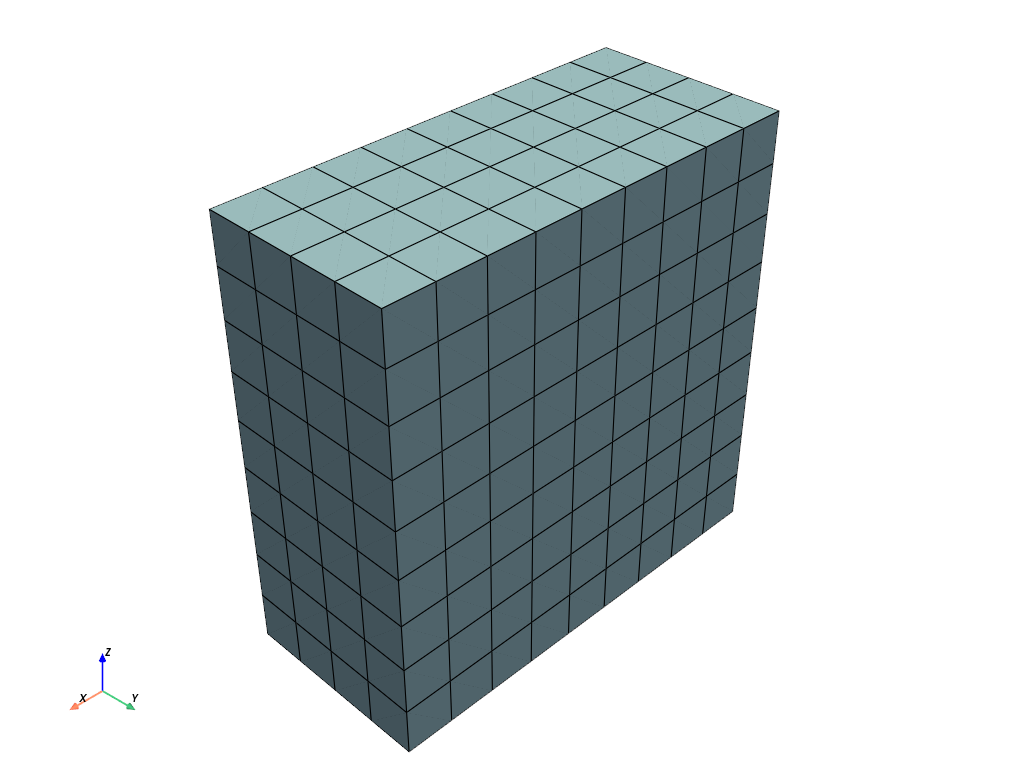

In [6]:
e_id = 1
for i, x in enumerate(
    [float(i) * length / float(num_nodes_in_length) for i in range(num_nodes_in_length - 1)]
):
    for j, y in enumerate(
        [float(i) * width / float(num_nodes_in_width) for i in range(num_nodes_in_width - 1)]
    ):
        for k, z in enumerate(
            [float(i) * depth / float(num_nodes_in_depth) for i in range(num_nodes_in_depth - 1)]
        ):
            coord1 = np.array([x, y, z])
            connectivity = []
            for xx in [x, x + length / float(num_nodes_in_length)]:
                for yy in [y, y + width / float(num_nodes_in_width)]:
                    for zz in [z, z + depth / float(num_nodes_in_depth)]:
                        data_index = search_sequence_numpy(flat_coordinates_data, [xx, yy, zz])
                        scoping_index = int(data_index / 3)  # 3components
                        connectivity.append(scoping_index)
            # rearrange connectivity
            tmp = connectivity[2]
            connectivity[2] = connectivity[3]
            connectivity[3] = tmp
            tmp = connectivity[6]
            connectivity[6] = connectivity[7]
            connectivity[7] = tmp
            mesh.elements.add_solid_element(e_id, connectivity)
            e_id += 1
mesh.plot()

Create displacement fields over time with three time sets. For the first
time set, the displacement on each node is the value of its x, y, and z
coordinates. For the second time set, the displacement on each node is
two times the value of its x, y, and z coordinates. For the third time
set, the displacement on each node is three times the value of its x, y,
and z coordinates.


In [7]:
num_nodes = mesh.nodes.n_nodes
time1_array = coordinates_data
time2_array = 2.0 * coordinates_data
time3_array = 3.0 * coordinates_data

time1_field = dpf.fields_factory.create_3d_vector_field(num_nodes)
time2_field = dpf.fields_factory.create_3d_vector_field(num_nodes)
time3_field = dpf.fields_factory.create_3d_vector_field(num_nodes)

time1_field.scoping = coordinates.scoping
time2_field.scoping = coordinates.scoping
time3_field.scoping = coordinates.scoping

time1_field.data = time1_array
time2_field.data = time2_array
time3_field.data = time3_array

time1_field.unit = mesh.unit
time2_field.unit = mesh.unit
time3_field.unit = mesh.unit

Create results over times in a fields container with its time frequency
support:


In [8]:
fc = dpf.fields_container_factory.over_time_freq_fields_container(
    {0.1: time1_field, 0.2: time2_field, 0.3: time3_field}, "s"
)

Check that the time frequency support has been built:


In [9]:
print(fc.time_freq_support)

DPF  Time/Freq Support: 
  Number of sets: 3 
Cumulative     Time (s)       LoadStep       Substep         
1              0.100000       1              1               
2              0.200000       1              2               
3              0.300000       1              3               



Plot the norm over time of the fields container:


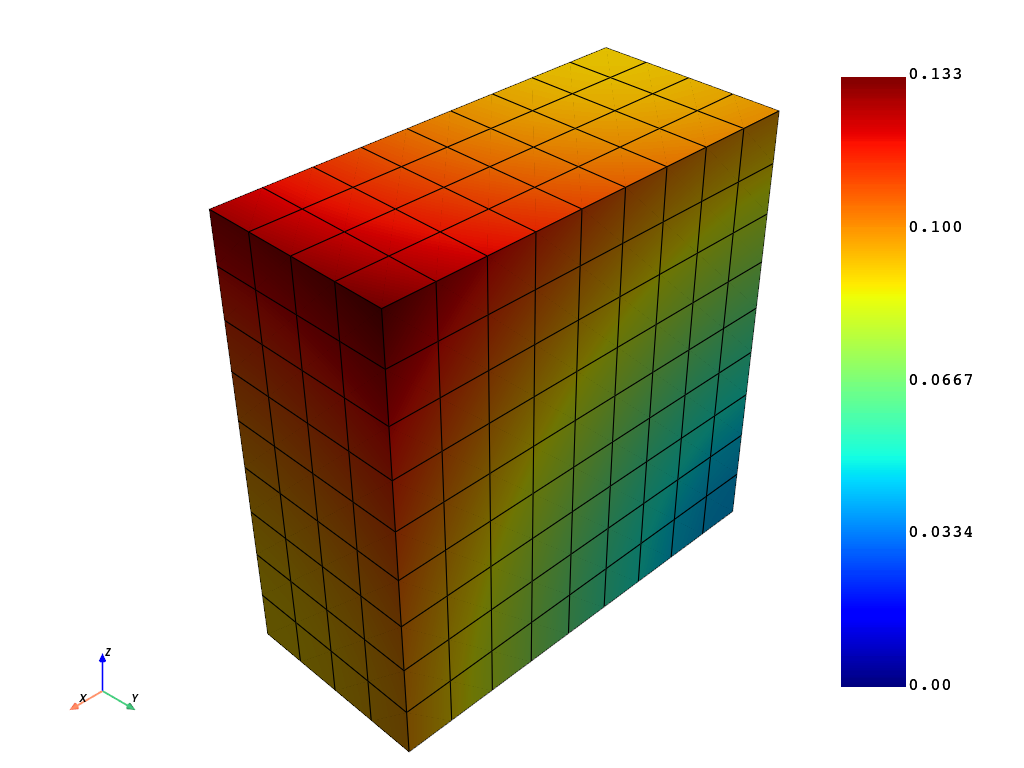

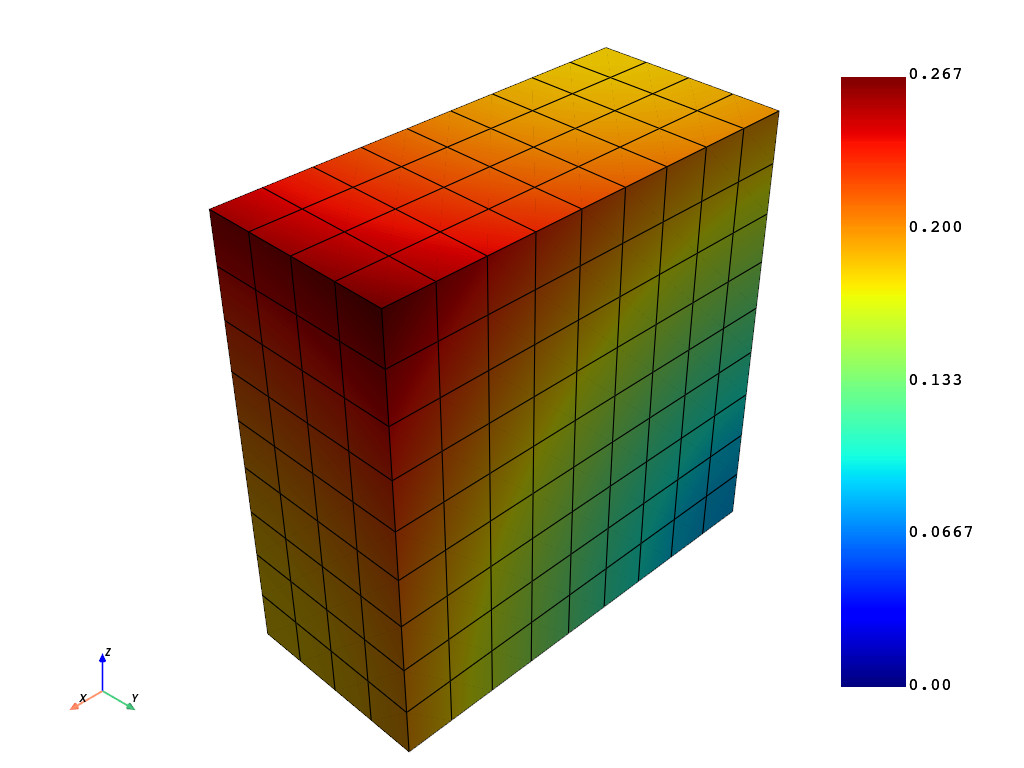

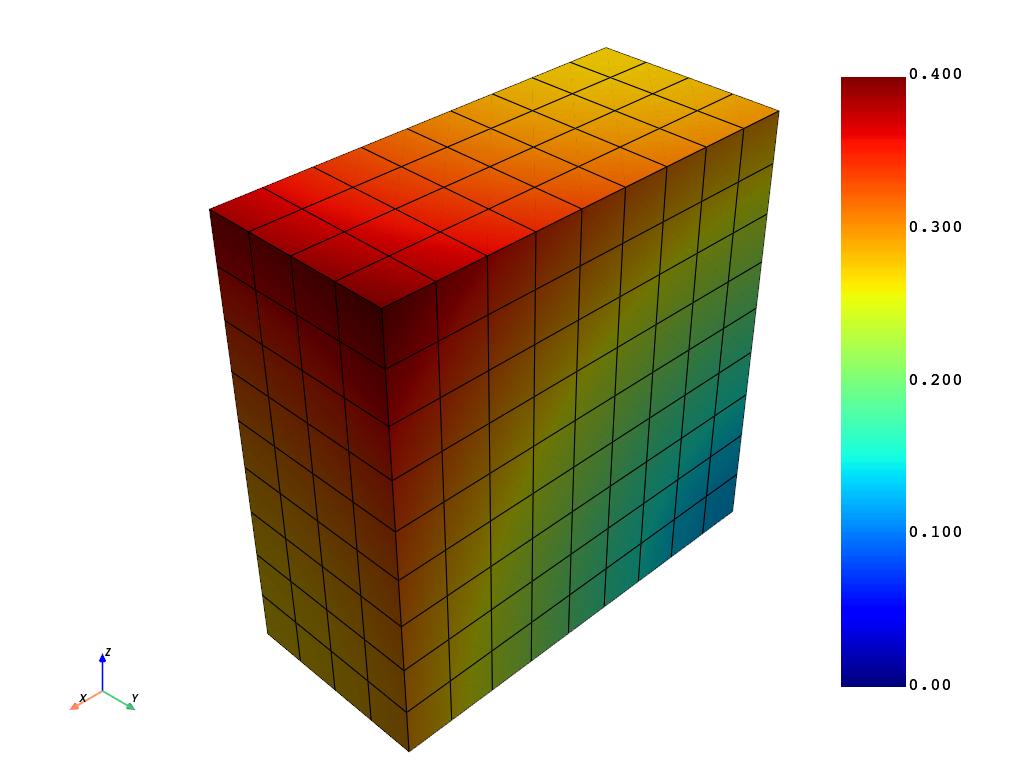

In [10]:
norm = ops.math.norm_fc(fc)
fc_norm = norm.outputs.fields_container()
mesh.plot(fc_norm.get_field_by_time_complex_ids(1))
mesh.plot(fc_norm.get_field_by_time_complex_ids(2))
mesh.plot(fc_norm.get_field_by_time_complex_ids(3))